In [1]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc
import shap
import joblib
import xgboost as xgb


In [2]:
default_path = '../../jiyoon/asset/default/mhcld_puf_2022.csv'
processed1_path = '../../jiyoon/asset/prepro3/단순결측치 행만 추출.csv'
processed2_path = '../../jiyoon/asset/prepro3/단순결측치 행 제거.csv'
processed3_path = '../../jiyoon/asset/prepro3/단순결측치 행 제거 후 지역별 차이 있는 칼럼 제거.csv'
processed4_path = '../../jiyoon/asset/prepro3/결측치가 포함된 모든 행 제거.csv'
processed5_path = '../../jiyoon/asset/prepro3/원핫인코딩_결측치가 포함된 모든 행 제거.csv'
processed6_path = '../../jiyoon/asset/prepro3/원핫인코딩_단순결측치 행 제거 후 지역별 차이 있는 칼럼 제거.csv'

In [3]:
dataset3 = pd.read_csv(processed3_path)

## 6.치료기관 분석

### 1. 기관별 이용 현황 분석




In [4]:
# 기관별 이용자 수 및 비율 계산

# 기관 변수 목록
service_cols = ['SPHSERVICE', 'CMPSERVICE', 'OPISERVICE', 'RTCSERVICE', 'IJSSERVICE']

# 각 기관별 이용자 수 및 비율 계산
for col in service_cols:
    print(f"\n {col} 이용자 현황")
    print(dataset3[col].value_counts(dropna=False))
    print(dataset3[col].value_counts(normalize=True, dropna=False).map(lambda x: f"{x:.2%}"))



 SPHSERVICE 이용자 현황
SPHSERVICE
0    5231293
1      86317
Name: count, dtype: int64
SPHSERVICE
0    98.38%
1     1.62%
Name: proportion, dtype: object

 CMPSERVICE 이용자 현황
CMPSERVICE
1    5160631
0     156979
Name: count, dtype: int64
CMPSERVICE
1    97.05%
0     2.95%
Name: proportion, dtype: object

 OPISERVICE 이용자 현황
OPISERVICE
0    5073946
1     243664
Name: count, dtype: int64
OPISERVICE
0    95.42%
1     4.58%
Name: proportion, dtype: object

 RTCSERVICE 이용자 현황
RTCSERVICE
0    5259532
1      58078
Name: count, dtype: int64
RTCSERVICE
0    98.91%
1     1.09%
Name: proportion, dtype: object

 IJSSERVICE 이용자 현황
IJSSERVICE
0    5271913
1      45697
Name: count, dtype: int64
IJSSERVICE
0    99.14%
1     0.86%
Name: proportion, dtype: object


In [5]:
# 개인별 기관 이용 개수 변수 생성

# 이용한 기관 수 (1값만 카운트)
dataset3['NUM_SERVICES_USED'] = (dataset3[service_cols] == 1).sum(axis=1)

# 분포 확인
print(dataset3['NUM_SERVICES_USED'].value_counts().sort_index())



NUM_SERVICES_USED
1    5062839
2     233880
3      19803
4       1061
5         27
Name: count, dtype: int64


In [6]:
# 기관이용 조합 탐색

# 기관 이용 조합 (ex: '01001' → 각 기관 이용여부를 문자열로 묶기)
# 각 서비스 이용 여부를 비트 자리로 간주하여 이진수로 인코딩 (01001 → 9)
dataset3['SERVICE_PATTERN_NUM'] = dataset3[service_cols].dot(1 << np.arange(len(service_cols)-1, -1, -1))

# 이진 패턴 문자열로 변환 (선택사항)
dataset3['SERVICE_PATTERN'] = dataset3['SERVICE_PATTERN_NUM'].apply(lambda x: format(x, f'0{len(service_cols)}b'))


# 조합별 빈도
print(dataset3['SERVICE_PATTERN'].value_counts().head(10))


SERVICE_PATTERN
01000    4910437
01100     138470
00100      83485
11000      43024
10000      30625
01001      24096
01010      23926
00010      21053
00001      17239
01110       8733
Name: count, dtype: int64


Step 1. 치료기관 이용 현황 분석 결과 요약

1-1. 각 기관별 이용률

- **CMPSERVICE** (지역사회 기반 정신건강 서비스) 이용자가 전체의 **97.05%**로 가장 많았으며, 이는 대부분의 클라이언트가 **비입원형, 외래 중심 치료**를 받은 것을 의미한다.
- **OPISERVICE** (기타 정신과 입원 시설) 이용자는 **4.58%**, 비교적 낮지만 입원 치료 경향을 반영한다.
- **SPHSERVICE** (주립 정신병원): **1.62%**만이 이용, 매우 제한적.
- **RTCSERVICE** (거주 치료 센터): **1.09%**로 일부 장기 주거 치료 중심.
- **IJSSERVICE** (교정시설 내 치료): **0.86%**, 비율은 적으나 사회적으로 특수한 환경임.

➡️ 전체적으로 **대부분의 클라이언트는 외래 중심의 지역사회 기반 기관(CMPSERVICE)만 이용**하고 있으며, 입원 치료나 특수 시설 이용은 제한적으로 나타남.

---

1-2. 치료기관 동시 이용 개수

- 한 사람이 이용한 기관 수를 합산한 결과:
  - **1개 기관만 이용**한 클라이언트가 **약 95.0% (5,062,839명)** 로 가장 많음
  - **2개 기관 동시 이용**: 233,880명 (약 4.4%)
  - **3개 이상** 동시 이용자도 소수 존재 (최대 5개 이용자도 27명 있음)

➡️ 대부분은 단일 기관 이용자지만, **중복 서비스 수혜자도 유의미하게 존재**하여, 이들에 대한 후속 분석이 가능함.

---

1-3. 기관 이용 패턴 (조합)

상위 10개의 기관 이용 조합을 보면:

| 패턴 | 의미 | 인원 |
|-------|------|------|
| `01000` | CMPSERVICE만 이용 | **4,910,437명** |
| `01100` | CMPSERVICE + OPISERVICE | 138,470명 |
| `00100` | OPISERVICE만 이용 | 83,485명 |
| `11000` | SPHSERVICE + CMPSERVICE | 43,024명 |
| `10000` | SPHSERVICE만 이용 | 30,625명 |
| `01001` | CMPSERVICE + IJSSERVICE | 24,096명 |
| `01010` | CMPSERVICE + RTCSERVICE | 23,926명 |
| `00010` | RTCSERVICE만 이용 | 21,053명 |
| `00001` | IJSSERVICE만 이용 | 17,239명 |
| `01110` | CMPSERVICE + OPISERVICE + RTCSERVICE | 8,733명 |

➡️ 가장 흔한 패턴은 **CMPSERVICE 단독 이용(01000)**이며,  
그 외에는 CMPSERVICE를 기반으로 입원형 또는 특수기관이 조합되는 경우가 많음.

---

시사점

- 대부분의 클라이언트는 **비입원형 외래 치료 중심의 서비스만 이용**하지만, 일부 클라이언트는 다중기관을 동시에 이용.
- 특히 CMPSERVICE와 OPISERVICE, RTCSERVICE 등의 조합은 **심화 치료, 복합 상태**, 또는 **특수한 상황(교정시설 등)**을 반영할 수 있어 **세부 특성 분석이 필요**함.
- 추후 분석에서는 이 `NUM_SERVICES_USED` 변수와 기관 조합 패턴을 활용해:
  - **입원 여부 파생 변수 생성**
  - **다중 이용자와 단일 이용자 비교**
  - **기관 수에 영향을 미치는 요인 분석** 등을 수행할 수 있음.


### 2. 입원 경험 파생 변수 생성 및 비교분석

SPHSERVICE, OPISERVICE, RTCSERVICE 중 하나라도 이용한 경우 → 입원 치료 경험이 있는 것으로 간주

파생 변수 INPATIENT를 만들어서:

인구통계적 특성(AGE, GENDER 등)

진단 수(NUMMHS), 물질사용문제(SAP), 고용상태(EMPLOY), 주거상태(LIVARAG) 등과의 차이점 분석

In [7]:
# IMPATIENT 변수 생성
# 입원치료 관련 서비스 중 하나라도 이용한 경우 1, 아니면 0
dataset3['INPATIENT'] = (
    (dataset3['SPHSERVICE'] == 1) |
    (dataset3['OPISERVICE'] == 1) |
    (dataset3['RTCSERVICE'] == 1)
).astype(int)

# 분포 확인
print(dataset3['INPATIENT'].value_counts())
print(dataset3['INPATIENT'].value_counts(normalize=True).map(lambda x: f"{x:.2%}"))



INPATIENT
0    4951772
1     365838
Name: count, dtype: int64
INPATIENT
0    93.12%
1     6.88%
Name: proportion, dtype: object


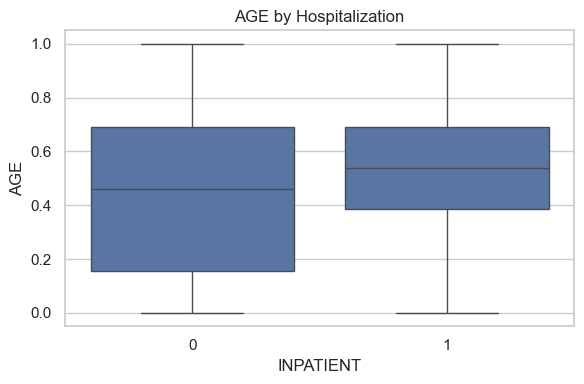

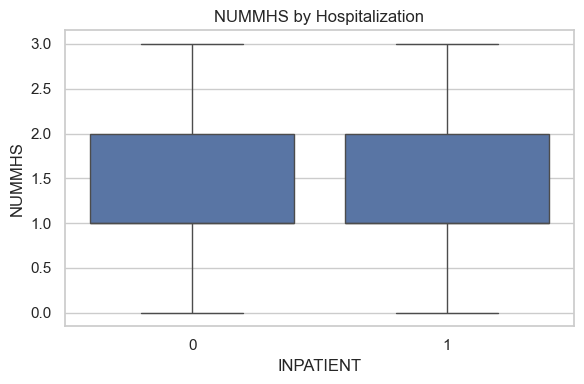

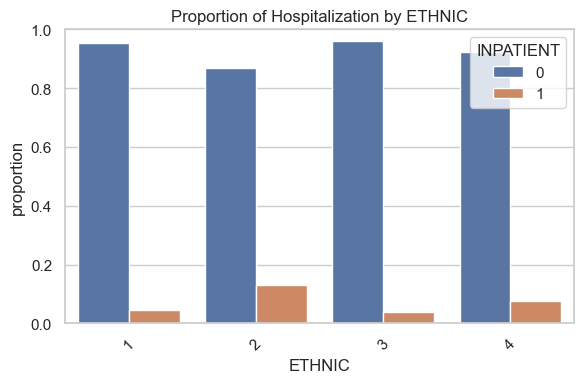

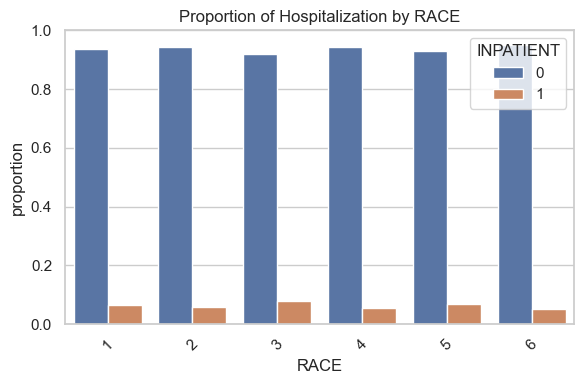

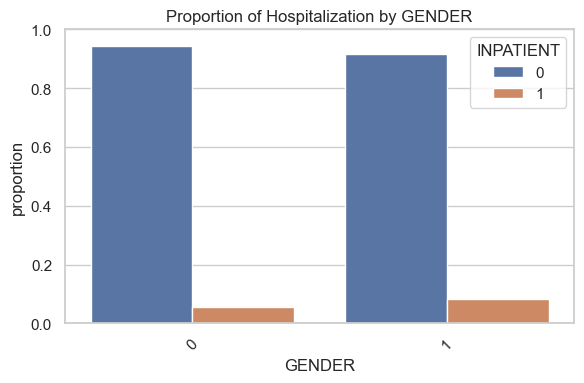

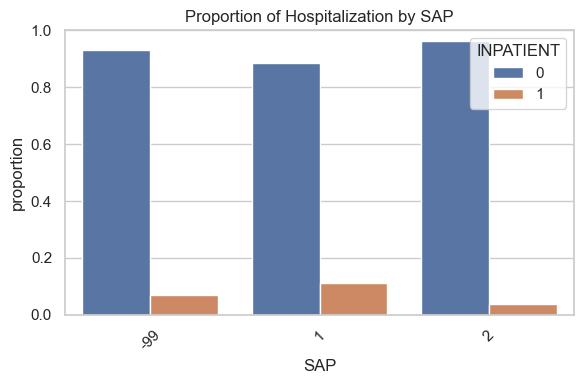

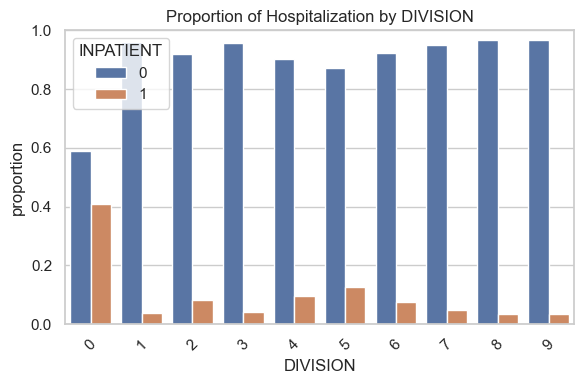

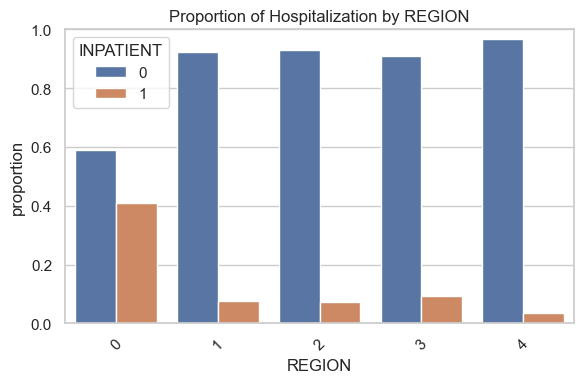

In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 입원 여부 변수명
target_col = 'INPATIENT'

# 수치형 / 범주형 변수
numeric_cols = ['AGE', 'NUMMHS']  # 연속형 변수
categorical_cols = ['ETHNIC', 'RACE', 'GENDER', 'SAP', 'DIVISION', 'REGION']  # 범주형 변수

sns.set(style="whitegrid")
n_cols = 2  # 한 줄에 2개씩 (boxplot 용)

### 1. 연속형 변수 → Boxplot (기존 그대로 유지)
for i, col in enumerate(numeric_cols):
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=target_col, y=col, data=dataset3)
    plt.title(f"{col} by Hospitalization")
    plt.tight_layout()
    plt.show()

### 2. 범주형 변수 → 비율 막대그래프
for col in categorical_cols:
    # 비율 계산
    prop_df = (
        dataset3
        .groupby(col)[target_col]
        .value_counts(normalize=True)
        .rename('proportion')
        .reset_index()
    )

    # 시각화
    plt.figure(figsize=(6, 4))
    sns.barplot(data=prop_df, x=col, y='proportion', hue=target_col)
    plt.title(f"Proportion of Hospitalization by {col}")
    plt.xticks(rotation=45)
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()


입원 치료 경험 분석

 1. INPATIENT 변수 개요

- `SPHSERVICE`, `OPISERVICE`, `RTCSERVICE` 중 하나 이상 이용한 클라이언트를 입원 치료 경험자로 정의하여 `INPATIENT` 변수 생성.
- 전체 클라이언트 중 **약 6.88%**가 입원 경험이 있었으며, 나머지 **93.12%는 외래 치료만 받음**.

| 구분 | 인원수 | 비율 |
|------|--------|------|
| 입원 경험 없음 (`INPATIENT=0`) | 4,951,772명 | 93.12% |
| 입원 경험 있음 (`INPATIENT=1`) |   365,838명 |  6.88% |

---

 2. 연속형 변수에 따른 입원 여부 차이

- **AGE (연령)**:
  - 입원 경험이 있는 그룹의 연령 중앙값이 더 높게 나타남.
  - → **입원 치료는 상대적으로 연령이 높은 클라이언트에게 더 빈번히 적용됨**.

- **NUMMHS (정신질환 진단 수)**:
  - 입원/비입원 집단 모두 평균 2개 미만의 진단을 받았고, 전반적으로 큰 차이가 없음. 

---

3. 범주형 변수별 입원 비율 비교

🔹 ETHNIC (히스패닉 여부)
- 푸에르토리코 출신(2번)의 입원 비율이 상대적으로 높았으며, 다른 그룹 대비 약 **10~15% 수준의 차이**가 존재.

🔹 RACE (인종)
- 전 인종 그룹에서 입원 경험 비율은 10% 미만으로 큰 차이는 없었으나,
- 일부 소수 인종 그룹에서 소폭 높은 입원 비율 관측.

🔹 GENDER (성별)
- **여성(1번)의 입원 비율이 남성보다 다소 높음**.
- 성별에 따라 치료 방식 접근성이 다를 수 있는 가능성 존재.

🔹 SAP (물질 사용 문제 여부)
- **SAP=1 (문제 있음)** 집단의 입원 비율이 가장 높음.
- → **물질 사용 문제는 입원치료 가능성을 높이는 핵심 요인** 중 하나로 보임.

🔹 DIVISION / REGION (인구조사 구역)
- 특정 지역(예: `DIVISION=0`, `REGION=0`)의 입원 비율이 매우 높음.
- → **지역 간 의료 접근성, 정책 차이, 보고 관행**이 입원 확률에 영향을 줄 수 있음.

---

 요약 및 시사점

- 입원 치료는 상대적으로 **나이가 많고**, **물질 사용 문제가 있는 사람**에게 더 자주 발생.
- 또한 **성별(GENDER)**, **출신(Ethnic/Race)**, **지역(REGION/DIVISION)** 요인도 입원 여부에 영향을 주는 것으로 보임.
- → 이후 분석에서 `INPATIENT`를 **예측 대상 변수로 지정**하고, 주요 요인을 규명하기 위한 **로지스틱 회귀 또는 트리 모델** 분석이 가능.



### 3. 기관 이용 개수에 영향을 주는 요인 분석
클라이언트가 이용한 기관 개수(NUM_SERVICES_USED)가 어떤 변수에 의해 영향을 받는지 분석

단순 비교를 넘어서 **예측 가능한 요인(나이, 성별, 진단 수 등)**을 식별



In [9]:
# 랜덤포레스트 만들 것이므로 원핫인코딩된 dataset6 사용
dataset6 = pd.read_csv(processed6_path)

dataset6['NUM_SERVICES_USED'] = (dataset3[service_cols] == 1).sum(axis=1)
print(dataset6['NUM_SERVICES_USED'].value_counts().sort_index())



NUM_SERVICES_USED
1    5062839
2     233880
3      19803
4       1061
5         27
Name: count, dtype: int64


In [8]:
# 예측에 사용할 변수 선택
target_col = 'NUM_SERVICES_USED'
feature_col = ['AGE','GENDER', 'SAP', 'NUMMHS', 'DIVISION', 'REGION' ]



NUM_SERVICES_USED
1    5062839
2     233880
3      19803
4       1061
5         27
Name: count, dtype: int64

In [10]:
dataset6.columns

Index(['YEAR', 'AGE', 'GENDER', 'SPHSERVICE', 'CMPSERVICE', 'OPISERVICE',
       'RTCSERVICE', 'IJSSERVICE', 'MH1', 'MH2', 'MH3', 'SAP', 'NUMMHS',
       'TRAUSTREFLG', 'ANXIETYFLG', 'ADHDFLG', 'CONDUCTFLG', 'DELIRDEMFLG',
       'BIPOLARFLG', 'DEPRESSFLG', 'ODDFLG', 'PDDFLG', 'PERSONFLG',
       'SCHIZOFLG', 'ALCSUBFLG', 'OTHERDISFLG', 'STATEFIP', 'CASEID', 'RACE_2',
       'RACE_3', 'RACE_4', 'RACE_5', 'RACE_6', 'ETHNIC_2', 'ETHNIC_3',
       'ETHNIC_4', 'REGION_1', 'REGION_2', 'REGION_3', 'REGION_4', 'SUB_1',
       'SUB_2', 'SUB_3', 'SUB_4', 'SUB_5', 'SUB_6', 'SUB_7', 'SUB_8', 'SUB_9',
       'SUB_10', 'SUB_11', 'SUB_12', 'SUB_13', 'SMISED_2', 'SMISED_3',
       'DETNLF_2', 'DETNLF_3', 'DETNLF_4', 'DETNLF_5', 'DETNLF_NotApplicable',
       'DIVISION_1', 'DIVISION_2', 'DIVISION_3', 'DIVISION_4', 'DIVISION_5',
       'DIVISION_6', 'DIVISION_7', 'DIVISION_8', 'DIVISION_9',
       'NUM_SERVICES_USED'],
      dtype='object')

In [11]:
import pandas as pd
import shap
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier


# 원핫인코딩
# 2. 'True', 'False' 문자열 → 1, 0 변환
for col in dataset6.columns:
    if dataset6[col].dtype == object:
        if set(dataset6[col].dropna().unique()) <= {"True", "False"}:
            dataset6[col] = dataset6[col].map({"True": 1, "False": 0}).astype(int)

# 3. object 타입 제거
dataset6 = dataset6.drop(columns=dataset6.select_dtypes(include='object').columns)

# ✅ 4. bool 타입을 int로 변환 (SHAP 오류 방지)
dataset6 = dataset6.astype({col: int for col in dataset6.select_dtypes('bool').columns})

# 6. 타겟과 피처 분리
y = dataset6["NUM_SERVICES_USED"]
X = dataset6.drop(columns=["YEAR", "SPHSERVICE","CMPSERVICE","OPISERVICE","RTCSERVICE",'IJSSERVICE','NUM_SERVICES_USED','CASEID'], errors="ignore")

# ✅ 7. 모든 피처 float 처리 (SHAP 계산 안정성 확보)
X = X.astype(float)

# 8. 모델 학습
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)
model.fit(X, y)


RandomForestClassifier(class_weight='balanced', max_depth=10, n_jobs=-1,
                       random_state=42)

PermutationExplainer explainer: 301it [00:53,  5.33it/s]                         



🔍 SHAP Summary for Class 0


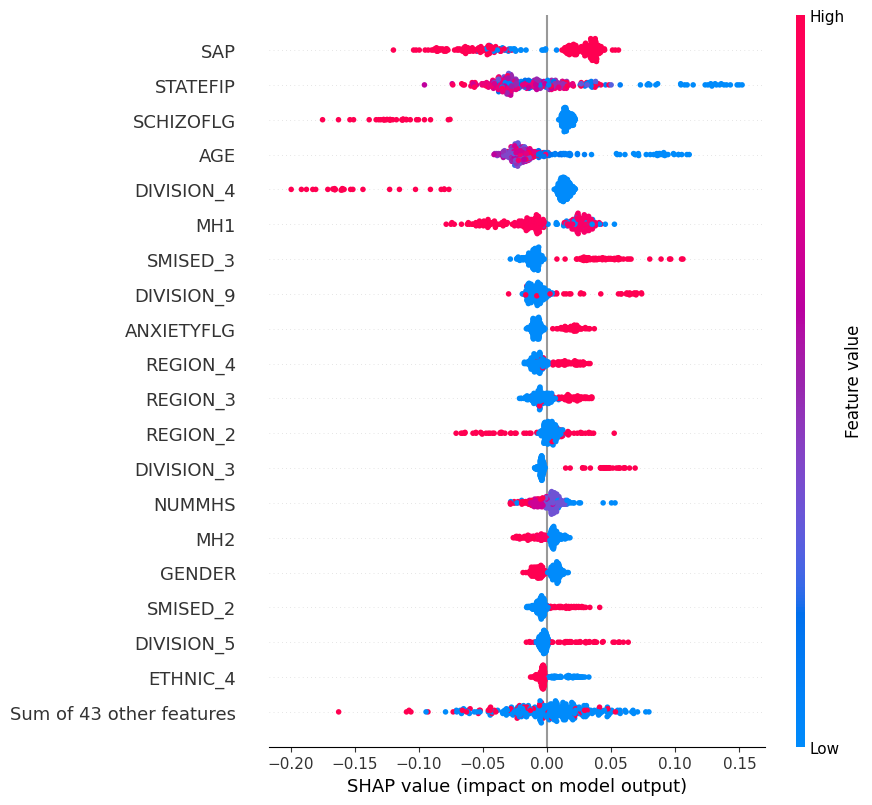


🔍 SHAP Summary for Class 1


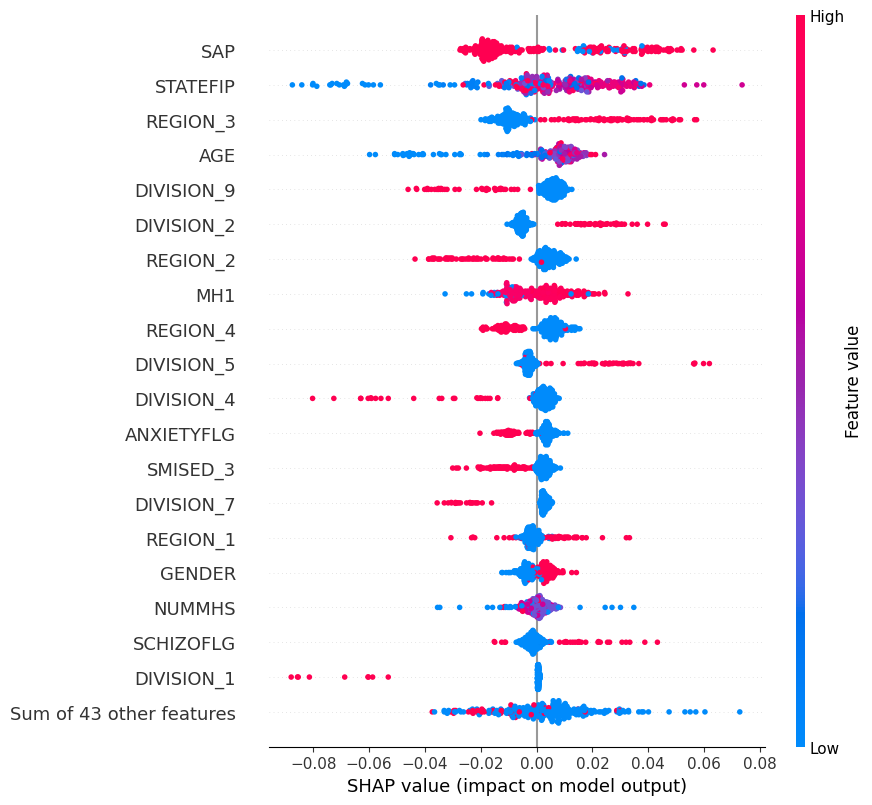


🔍 SHAP Summary for Class 2


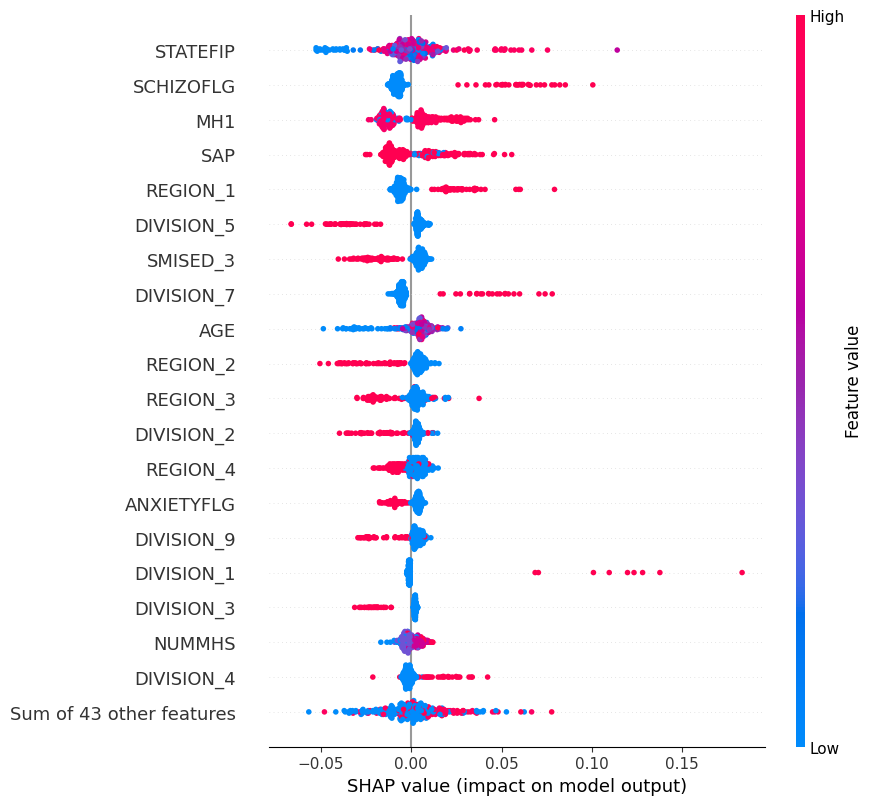


🔍 SHAP Summary for Class 3


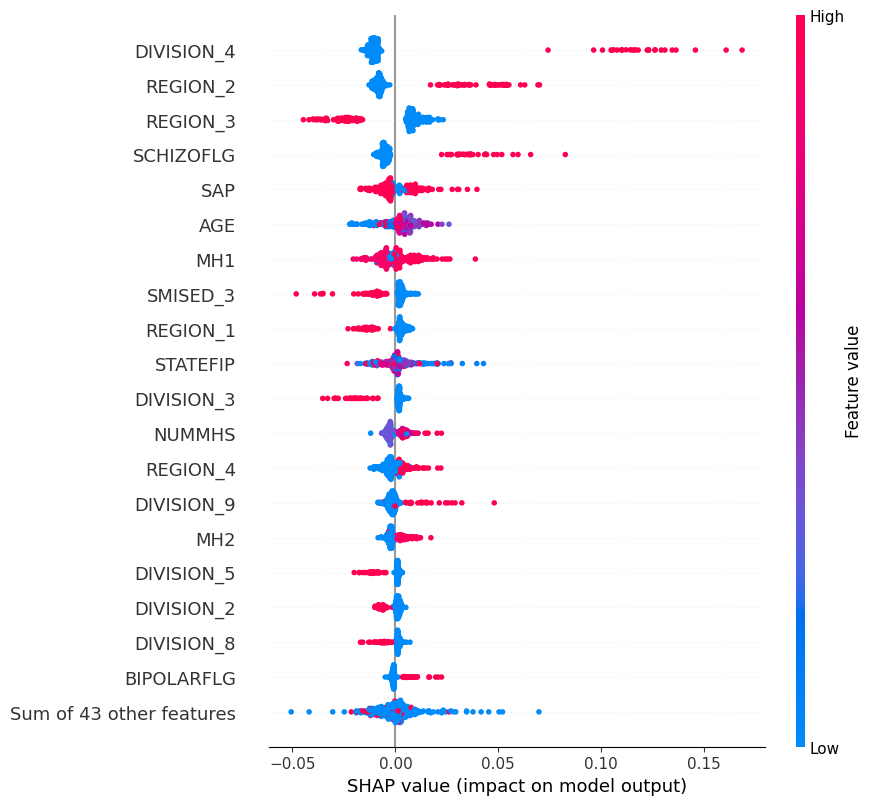


🔍 SHAP Summary for Class 4


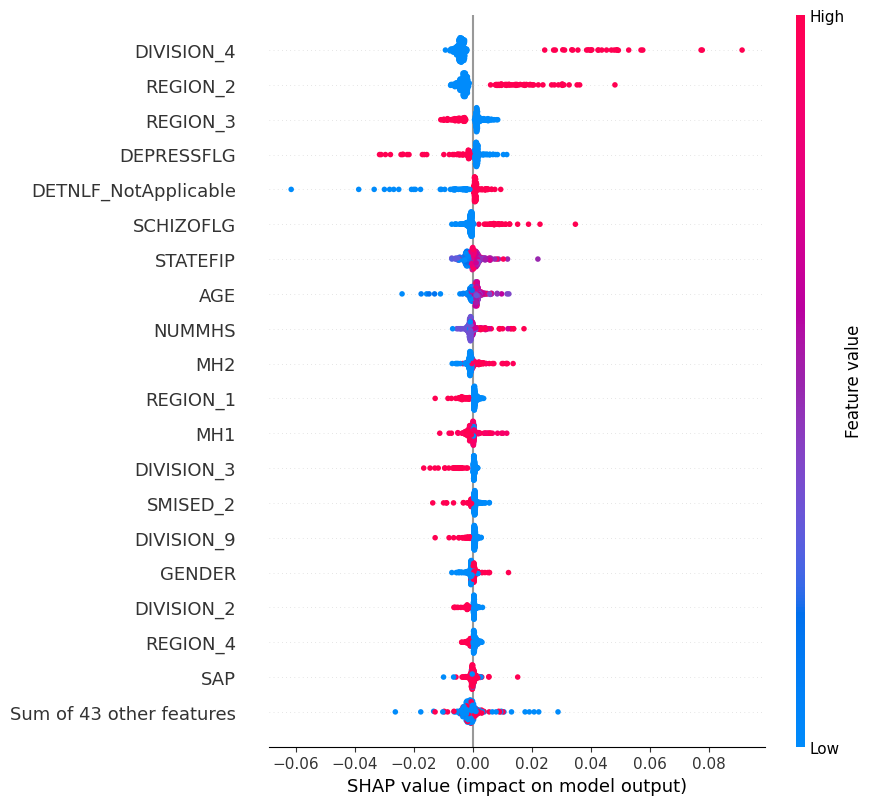

정확도 (Accuracy): 0.6797


In [12]:

from sklearn.metrics import accuracy_score


# 9. 샘플 추출 (SHAP 계산 속도 최적화)
X_sample = X.sample(n=300, random_state=42)

# 10. SHAP Explainer 정의 (predict_proba 기반)
def predict_proba_fn(X_input):
    return model.predict_proba(X_input)

explainer = shap.Explainer(predict_proba_fn, X_sample)
shap_values = explainer(X_sample)

# 11. 클래스 이름 정의
class_ids = model.classes_
class_names = {i: f"{i+1}" for i in class_ids}

# 12. 클래스별 SHAP summary plot
for i in range(shap_values.values.shape[2]):
    print(f"\n🔍 SHAP Summary for Class {class_names.get(i, str(i))}")
    shap.plots.beeswarm(shap_values[:, :, i], max_display=20)

# ✅ 예측값 생성
y_pred = model.predict(X)

# ✅ 정확도 계산
acc = accuracy_score(y, y_pred)
print(f"정확도 (Accuracy): {acc:.4f}")



분석결과

**1개 기관 이용자 (`NUM_SERVICES_USED = 1`)**

* **SAP**(Substance Abuse Problem): 매우 강한 양의 영향 → SAP가 있는 사람일수록 1개 기관만 이용한 예측 증가
* **STATEFIP**: 특정 주(State)의 영향력 뚜렷
* **SCHIZOFLG**: 조현병 진단 여부가 높은 영향을 미침
* **AGE**: 나이 분포도 영향을 줌 (중간 연령대에 영향력)
* **MH1** (1차 정신질환 코드)도 영향력 상위

📝 `1개 기관 이용자`는 **물질 사용 문제**와 **특정 진단 유무**에 강하게 반응하는 그룹

---

**2개 기관 이용자**

* `SAP`, `STATEFIP`, `REGION_3`, `AGE` 가 여전히 상위
* `DIVISION_9`, `DIVISION_2` 등 지역적 특성이 강조됨
* `MH1`, `REGION_4`, `ANXIETYFLG`, `SMISED_3` 등 **정신질환 관련 변수**들도 영향력 증가

📝 `2기관 이용자`는 **지역적 특성과 진단 유형의 조합**이 중요한 요소로 작용

---

**3개 기관 이용자**

* **조현병(SCHIZOFLG)** 영향이 상위 → 중증 질환자일 가능성
* `MH1`, `SAP`, `DIVISION_7`, `REGION_1`, `AGE` 영향 유지
* 전반적으로 고위험군 특성이 강조됨

📝 `3기관 이용자`는 **조현병, 다중 진단, 특정 지역적 요인**이 결합된 고위험군 패턴

---

**4개 기관 이용자**

* 상위 변수: `DIVISION_4`, `REGION_2`, `REGION_3`, `SCHIZOFLG`, `SAP`
* `AGE`, `MH1`, `STATEFIP`도 유지
* **DIVISION\_4 지역**에서 유독 높게 SHAP값 분포

📝 `4기관 이용자`는 **조현병 진단자 및 특정 지역(예: DIV4, REG2)** 중심으로 예측됨

---

**5개 기관 이용자**

* 특이하게 \*\*`DIVISION_4`와 `REGION_2`\*\*가 압도적으로 영향력 큼
* `DEPRESSFLG` (우울장애), `SCHIZOFLG`, `MH2`, `NUMMHS`도 포함됨
* **정신건강 진단 수가 많고**, **다수 진단이 복합적으로 존재**

📝 `5기관 이용자`는 **중증 중복 진단자**이며, **특정 지역에서만 집중적으로 나타나는 고위험군**일 가능성 있음

---

결론 요약

| Class | 주요 영향 변수                                   | 해석 요약                           |
| ----- | ------------------------------------------ | ------------------------------- |
| 1개 기관 | SAP, STATEFIP, SCHIZOFLG, AGE              | 물질 사용 문제와 경도 진단 위주, 비교적 보편적인 그룹 |
| 2개 기관 | SAP, MH1, 지역구분 (DIV, REG)                  | 정신질환 + 지역적 요인이 복합 작용            |
| 3개 기관 | SCHIZOFLG, SMISED, MH1                     | 중증 정신질환 진단자 위주                  |
| 4개 기관 | SCHIZOFLG, DIVISION\_4, REGION\_2          | 특정 지역 기반 중증 진단자                 |
| 5개 기관 | DIVISION\_4, REGION\_2, DEPRESSFLG, NUMMHS | 다중 진단 + 고위험군 + 특정 지역 집중         |

각 클래스별 개수가 매우 크게 차이나므로 제대로 된 분석일지 잘 모르겠음... 


